In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # 前向传播时存特征图 目标输出
        target_layer.reister_forward_hook(self._save_activations)
        
        # 反向传播时存梯度 = ∂(target_layer_output)/∂(model_output)
        target_layer.register_backward_hook(self._save_gradients)
        
    def _save_activations(self, module, input, output):
        self.activations = output.detach()
        
    def _save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
        
    def __call__(self, x, class_idx=None):
        # Forward pass
        output = self.model(x)
        if class_idx is None:
            class_idx = torch.argmax(output).item()
            
        # 反向传播计算梯度
        one_hot = torch.zeros_like(output)
        one_hot[0][class_idx] = 1       # 创建目标类别的one-hot向量
        output.backward(gradient=one_hot) # 指定类别的反向传播
        
        # 计算权重
        pooled_gradients = torch.mean(self.gradients, dim=[2, 3, 4])
        weights_activations = torch.zeros_like(self.activations)
        
        for i in range(self.activations.shape[1]):
            weights_activations[:, i, ...] = self.activations[:, i, ...] * pooled_gradients[i]
            
        heatmap = torch.mean(weights_activations, dim=1).squeeze()
        heatmap = np.max(heatmap.numpy(), axis=0)
        
        heatmap = np.maximum(heatmap, 0)
        
        
        return heatmap
        
        
        
        

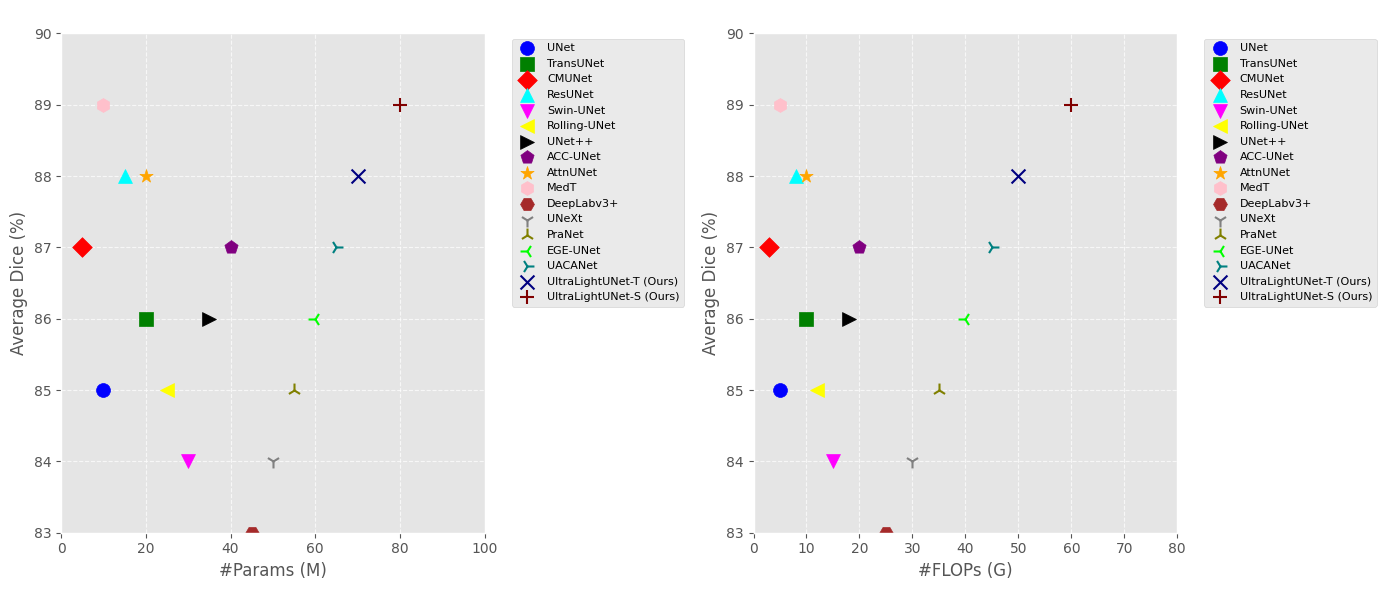

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# 模拟数据（根据你的图表内容调整）
methods = [
    "UNet", "TransUNet", "CMUNet", "ResUNet", "Swin-UNet", "Rolling-UNet",
    "UNet++", "ACC-UNet", "AttnUNet", "MedT", "DeepLabv3+", "UNeXt",
    "PraNet", "EGE-UNet", "UACANet", "UltraLightUNet-T (Ours)", "UltraLightUNet-S (Ours)"
]

# 左图数据（参数量 vs Dice）
params = np.array([10, 20, 5, 15, 30, 25, 35, 40, 20, 10, 45, 50, 55, 60, 65, 70, 80])
dice_left = np.array([85, 86, 87, 88, 84, 85, 86, 87, 88, 89, 83, 84, 85, 86, 87, 88, 89])

# 右图数据（计算量 vs Dice）
flops = np.array([5, 10, 3, 8, 15, 12, 18, 20, 10, 5, 25, 30, 35, 40, 45, 50, 60])
dice_right = np.array([85, 86, 87, 88, 84, 85, 86, 87, 88, 89, 83, 84, 85, 86, 87, 88, 89])

# 标记和颜色映射
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', '1', '2', '3', '4', 'x', '+']
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'purple', 'orange', 'pink',
          'brown', 'gray', 'olive', 'lime', 'teal', 'navy', 'maroon']

# 创建图形
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# 绘制左图
for i, method in enumerate(methods):
    ax1.scatter(params[i], dice_left[i], marker=markers[i], color=colors[i], label=method, s=100)

ax1.set_xlabel('#Params (M)', fontsize=12)
ax1.set_ylabel('Average Dice (%)', fontsize=12)
ax1.set_title('Params vs Dice', fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_xlim(0, 100)
ax1.set_ylim(83, 90)

# 将图例放在左图外部
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, labelcolor='black')

# 绘制右图
for i, method in enumerate(methods):
    ax2.scatter(flops[i], dice_right[i], marker=markers[i], color=colors[i], label=method, s=100)

ax2.set_xlabel('#FLOPs (G)', fontsize=12)
ax2.set_ylabel('Average Dice (%)', fontsize=12)
ax2.set_title('FLOPs vs Dice', fontsize=14)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.set_xlim(0, 80)
ax2.set_ylim(83, 90)

# 将图例放在右图外部
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, labelcolor='black')

# 调整布局
plt.tight_layout()

# 保存或显示图表
plt.show()
plt.close()

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DynamicConvolution(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, num_kernels):
        super(DynamicConvolution, self).__init__()
        self.num_kernels = num_kernels
        self.kernel_size = kernel_size
        self.in_channels = in_channels
        self.out_channels = out_channels

        # 定义一组并行的卷积核
        self.convs = nn.ModuleList([
            nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2)
            for _ in range(num_kernels)
        ])

        # 注意力机制：优化后的实现
        self.global_avg_pool = nn.AdaptiveAvgPool3d(1)
        self.global_max_pool = nn.AdaptiveMaxPool3d(1)
        self.fc1 = nn.Linear(in_channels * 2, in_channels // 16)
        self.bn1 = nn.BatchNorm1d(in_channels // 16)
        self.dropout1 = nn.Dropout(0.2)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(in_channels // 16, num_kernels)
        self.bn2 = nn.BatchNorm1d(num_kernels)
        self.dropout2 = nn.Dropout(0.2)
        self.softmax = nn.Softmax(dim=1)

        # 通道间的注意力机制
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool3d(1),
            nn.Conv3d(in_channels, in_channels // 16, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(in_channels // 16, in_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # 通道间的注意力机制
        channel_attention = self.channel_attention(x)
        x_attention = x * channel_attention

        # 计算注意力权重
        avg_pool = self.global_avg_pool(x_attention)
        max_pool = self.global_max_pool(x_attention)
        attention = torch.cat([avg_pool, max_pool], dim=1)
        attention = attention.view(attention.size(0), -1)
        attention = self.fc1(attention)
        attention = self.bn1(attention)
        attention = self.dropout1(attention)
        attention = self.relu(attention)
        attention = self.fc2(attention)
        attention = self.bn2(attention)
        attention = self.dropout2(attention)
        attention = self.softmax(attention)
        attention = attention.view(attention.size(0), 1, self.num_kernels, 1, 1, 1)  # 调整维度

        # 动态卷积
        outputs = []
        for i in range(self.num_kernels):
            outputs.append(self.convs[i](x_attention))
        outputs = torch.stack(outputs, dim=1)  # (batch_size, num_kernels, out_channels, depth, height, width)

        # 应用注意力权重
        outputs = outputs * attention
        outputs = outputs.sum(dim=1)  # (batch_size, out_channels, depth, height, width)

        return outputs

# 使用示例
if __name__ == "__main__":
    # 创建一个示例输入
    batch_size = 2
    in_channels = 16
    out_channels = 32
    kernel_size = 3
    num_kernels = 4
    depth = 128
    height = 128
    width = 128

    x = torch.randn(batch_size, in_channels, depth, height, width)

    # 创建动态卷积层
    dynamic_conv = DynamicConvolution(in_channels, out_channels, kernel_size, num_kernels)

    # 前向传播
    output = dynamic_conv(x)

    print("Input shape:", x.shape)
    print("Output shape:", output.shape)

RuntimeError: The size of tensor a (32) must match the size of tensor b (4) at non-singleton dimension 2